In [1]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

In [2]:
client = bigquery.Client(project='subugoe-collaborative')

In [3]:
s2ag_papers = 'subugoe-collaborative.semantic_scholar.papers'
s2ag_venues = 'subugoe-collaborative.semantic_scholar.venues'
openalex_snapshot = 'subugoe-collaborative.openalex.works'
cr_snapshot = 'subugoe-collaborative.cr_instant.snapshot'

In [4]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=9) 
plt.rc('axes', titlesize=9) 
plt.rc('axes', labelsize=9) 
plt.rc('xtick', labelsize=9) 
plt.rc('ytick', labelsize=9) 
plt.rc('legend', fontsize=9)

In [5]:
oal_c = client.query(f"""
                    SELECT COUNT(DISTINCT(oal.doi)) AS n
                    FROM {openalex_snapshot} AS oal
                    WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                        AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                    """).to_dataframe()

In [6]:
oal_c

,n
0,39908593


In [7]:
s2_c = client.query(f"""
                    SELECT COUNT(DISTINCT(externalids.DOI)) AS n
                    FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                    WHERE s2.year BETWEEN 2015 AND 2023 AND ptype IN ('JournalArticle', 'Review')
                    """).to_dataframe()

In [8]:
s2_c

,n
0,20293269


In [9]:
cr_c = client.query(f"""
                    SELECT COUNT(DISTINCT(cr.doi)) AS n
                    FROM {cr_snapshot} AS cr
                    LEFT JOIN {openalex_snapshot} AS oal
                        ON LOWER(cr.doi) = LOWER(oal.doi)
                    LEFT JOIN {s2ag_papers} AS s2
                        ON LOWER(cr.doi) = LOWER(s2.externalids.DOI)
                    WHERE cr.type = 'journal-article' AND issued >= '2015-01-01' 
                        AND issued < '2024-01-01' AND issued IS NOT NULL AND s2.externalids.DOI IS NULL AND oal.doi IS NULL
                    """).to_dataframe()

In [10]:
cr_c

,n
0,10248


In [11]:
oal_s2_cr_c = client.query(f"""
                            SELECT COUNT(DISTINCT(oal.doi)) AS n
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            JOIN {openalex_snapshot} AS oal
                                ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                            JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                AND oal.primary_location.source.type = 'journal'
                                AND oal.type IN ('article', 'review') 
                                AND ptype IN ('JournalArticle', 'Review') 
                                AND cr.type='journal-article' 
                                AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [12]:
oal_s2_cr_c

,n
0,16984612


In [13]:
oal_s2_c = client.query(f"""
                         SELECT COUNT(DISTINCT(oal.doi)) AS n
                         FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                         JOIN {openalex_snapshot} AS oal
                             ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                         WHERE oal.publication_year BETWEEN 2015 AND 2023 
                             AND oal.primary_location.source.type = 'journal'
                             AND oal.type IN ('article', 'review')
                             AND ptype IN ('JournalArticle', 'Review')
                             AND is_paratext=False
                         """).to_dataframe()

In [14]:
oal_s2_c

,n
0,17150496


In [15]:
oal_cr_c = client.query(f"""
                         SELECT COUNT(DISTINCT(oal.doi)) AS n
                         FROM {openalex_snapshot} AS oal
                         JOIN {cr_snapshot} AS cr
                             ON LOWER(oal.doi) = LOWER(cr.doi)
                         LEFT JOIN {s2ag_papers} AS s2
                             ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                         WHERE oal.publication_year BETWEEN 2015 AND 2023 
                             AND oal.primary_location.source.type = 'journal'
                             AND oal.type IN ('article', 'review')
                             AND cr.type='journal-article' 
                             AND is_paratext=False 
                             AND is_retracted=False 
                             AND s2.externalids.DOI IS NULL
                         """).to_dataframe()

In [16]:
oal_cr_c

,n
0,2146453


In [17]:
s2_cr_c = client.query(f"""
                         SELECT COUNT(DISTINCT(s2.externalids.DOI)) AS n
                         FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                         JOIN {cr_snapshot} AS cr
                             ON LOWER(s2.externalids.DOI) = LOWER(cr.doi)
                         LEFT JOIN {openalex_snapshot} AS oal
                             ON LOWER(s2.externalids.DOI) = LOWER(oal.doi)
                         WHERE s2.year BETWEEN 2015 AND 2023 
                             AND ptype IN ('JournalArticle', 'Review')
                             AND oal.doi IS NULL
                         """).to_dataframe()

In [18]:
s2_cr_c

,n
0,5228


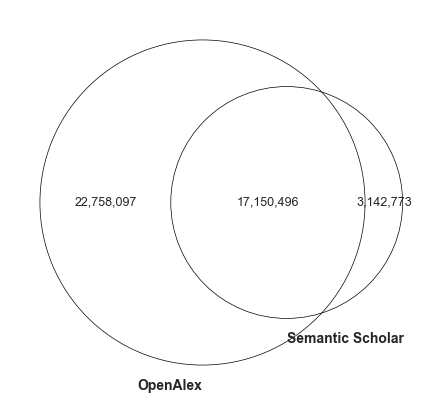

In [19]:
fig, ax = plt.subplots(figsize=(6,5))

subsets = (39908593-17150496, 20293269-17150496, 17150496)

out = venn2(subsets=subsets, 
      set_labels=('OpenAlex', 'Semantic Scholar'),
      set_colors=('white', 'white'),
      alpha=0.7)

venn2_circles(subsets=subsets, 
              linewidth=0.5)

for text in out.set_labels:
    text.set_font('Arial')
    text.set_fontsize(10)
    text.set_fontweight('bold')
for text in out.subset_labels:
    text.set_font('Arial')
    text.set_fontsize(9)
    s = int(text.get_text())
    text.set_text(f"{s:,}")
    
plt.show()
fig.savefig(f'media/venn_s2_oal.png', format='png', bbox_inches='tight', dpi=500)

In [20]:
oal_s2_ref_sum = client.query(f"""
                                SELECT 
                                    SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                    SUM(s2.referencecount) AS s2_ref_sum
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [21]:
oal_s2_ref_sum

,oal_ref_sum,s2_ref_sum
0,982585826,994263247


In [25]:
oal_s2_ref_avg = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [26]:
oal_s2_ref_avg

,oal_ref_avg,s2_ref_avg
0,25.522977,25.826302


In [27]:
oal_ref_sum = client.query(f"""
                            SELECT 
                                SUM(oal.referenced_works_count) AS oal_ref_sum, 
                            FROM {openalex_snapshot} AS oal
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [28]:
oal_ref_sum

,oal_ref_sum
0,979574990


In [29]:
oal_ref_avg = client.query(f"""
                            SELECT 
                                AVG(oal.referenced_works_count) AS oal_ref_avg, 
                            FROM {openalex_snapshot} AS oal
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                            """).to_dataframe()

In [30]:
oal_ref_avg

,oal_ref_avg
0,20.506328


In [32]:
s2_ref_sum = client.query(f"""
                            SELECT 
                                SUM(s2.referencecount) AS s2_ref_sum
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            WHERE s2.year BETWEEN 2015 AND 2023 AND ptype IN ('JournalArticle', 'Review')
                            """).to_dataframe()

In [33]:
s2_ref_sum

,s2_ref_sum
0,890745379


In [34]:
s2_ref_avg = client.query(f"""
                            SELECT 
                                AVG(s2.referencecount) AS s2_ref_avg
                            FROM {s2ag_papers} AS s2, UNNEST(publicationtypes) AS ptype
                            WHERE s2.year BETWEEN 2015 AND 2023 AND ptype IN ('JournalArticle', 'Review')
                            """).to_dataframe()

In [35]:
s2_ref_avg

,s2_ref_avg
0,36.149792


In [27]:
oal_cr_s2_ref_y = client.query(f"""
                            SELECT 
                                SUM(oal.referenced_works_count) AS oal_ref_sum,
                                AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                SUM(s2.referencecount) AS s2_ref_sum,
                                AVG(s2.referencecount) AS s2_ref_avg,
                                SUM(cr.references_count) AS cr_ref_sum,
                                AVG(cr.references_count) AS cr_ref_avg,
                                oal.publication_year
                            FROM {openalex_snapshot} AS oal
                            JOIN {s2ag_papers} AS s2
                                ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                            JOIN {cr_snapshot} AS cr
                                ON LOWER(oal.doi) = LOWER(cr.doi)
                            WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                            GROUP BY publication_year
                            """).to_dataframe()

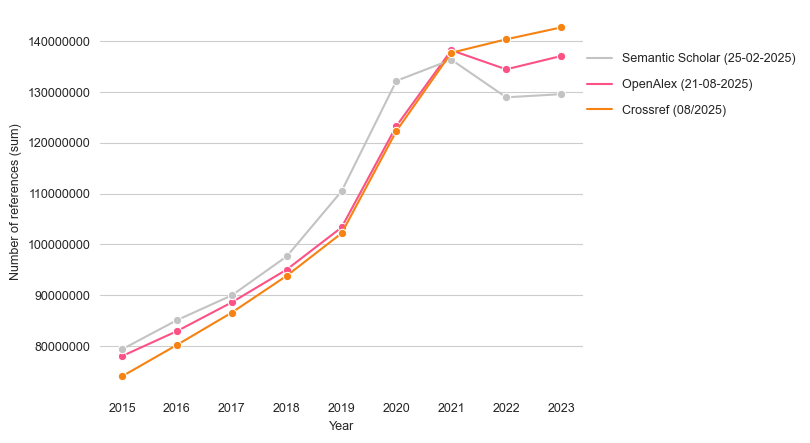

In [28]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_cr_s2_ref_y[['oal_ref_sum', 'publication_year']],
             x='publication_year',
             y='oal_ref_sum',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_ref_y[['s2_ref_sum', 'publication_year']],
             x='publication_year',
             y='s2_ref_sum',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_ref_y[['cr_ref_sum', 'publication_year']],
             x='publication_year',
             y='cr_ref_sum',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of references (sum)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (21-08-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (08/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/s2_oal_cr_sum_ref.png', format='png', bbox_inches='tight', dpi=500)

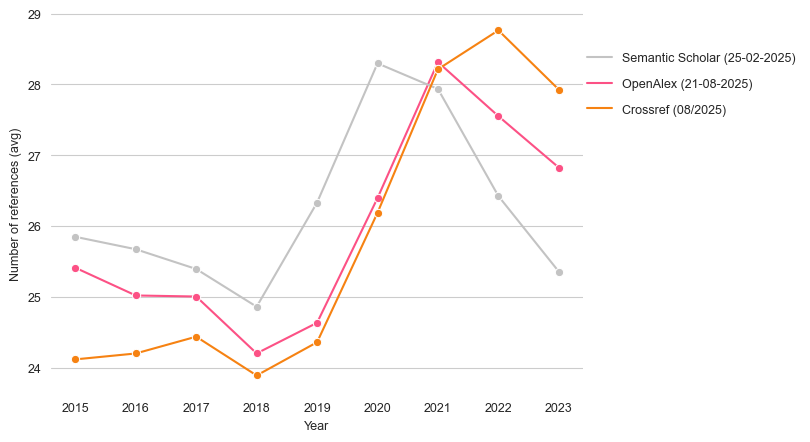

In [29]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_cr_s2_ref_y[['oal_ref_avg', 'publication_year']],
             x='publication_year',
             y='oal_ref_avg',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_ref_y[['s2_ref_avg', 'publication_year']],
             x='publication_year',
             y='s2_ref_avg',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_ref_y[['cr_ref_avg', 'publication_year']],
             x='publication_year',
             y='cr_ref_avg',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of references (avg)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (21-08-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (08/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/s2_oal_cr_avg_ref.png', format='png', bbox_inches='tight', dpi=500)

In [30]:
oal_cr_s2_ref_y.sort_values(by=['publication_year'])

,oal_ref_sum,oal_ref_avg,s2_ref_sum,s2_ref_avg,cr_ref_sum,cr_ref_avg,publication_year
7,78018465,25.410640,79359213,25.847322,74045062,24.116501,2015
1,82936005,25.018954,85099964,25.671746,80221082,24.199954,2016
6,88603153,25.004100,89980479,25.392786,86594277,24.437188,2017
3,95054352,24.200929,97643766,24.860196,93830600,23.889361,2018
0,103352214,24.633324,110474499,26.330874,102199164,24.358502,2019
5,123327004,26.394183,132216311,28.296653,122357144,26.186615,2020
8,138233105,28.314219,136381406,27.934937,137740977,28.213417,2021
4,134473193,27.551217,128965769,26.422842,140387446,28.762945,2022
2,137095196,26.824769,129586550,25.355587,142722982,27.925931,2023


In [31]:
oal_s2_ref_avg_y = client.query(f"""
                                SELECT 
                                    AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                    AVG(s2.referencecount) AS s2_ref_avg,
                                    AVG(cr.references_count) AS cr_ref_avg
                                FROM {openalex_snapshot} AS oal
                                JOIN {s2ag_papers} AS s2
                                    ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                JOIN {cr_snapshot} AS cr
                                    ON LOWER(oal.doi) = LOWER(cr.doi)
                                WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                    AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                                """).to_dataframe()

In [32]:
oal_s2_ref_avg_y

,oal_ref_avg,s2_ref_avg,cr_ref_avg
0,26.094036,26.323176,26.0676


In [45]:
oal_s2_ref_avg_per_journal = client.query(f"""
                                           SELECT 
                                               AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                               AVG(s2.referencecount) AS s2_ref_avg,
                                               oal.primary_location.source.display_name AS journal_title
                                           FROM {openalex_snapshot} AS oal
                                           JOIN {s2ag_papers} AS s2
                                               ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                           WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                               AND oal.primary_location.source.type = 'journal'
                                               AND oal.type IN ('article', 'review') 
                                               AND is_paratext=False 
                                               AND is_retracted=False
                                           GROUP BY journal_title
                                           """).to_dataframe()

In [46]:
oal_s2_ref_avg_per_journal

,oal_ref_avg,s2_ref_avg,journal_title
0,59.437448,59.685255,Journal of Hydrology
1,7.536585,7.591463,Documentación de las Ciencias de la Información
2,1.092784,4.185567,Revista Brasileira de História do Direito
3,11.732919,14.178054,Journal of College of Medical Sciences-Nepal
4,20.646766,31.185323,International journal of engineering research ...
...,...,...,...
109150,0.000000,0.000000,SCIREA journal of energy.
109151,0.000000,0.000000,小児科
109152,0.000000,0.000000,Journal of the fantastic in the arts
109153,0.000000,0.000000,Index of Texas Archaeology: Open Access Gray L...


In [60]:
oal_s2_ref_sum_per_journal = client.query(f"""
                                           SELECT 
                                               SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                               SUM(s2.referencecount) AS s2_ref_sum,
                                               oal.primary_location.source.id AS journal_title
                                           FROM {openalex_snapshot} AS oal
                                           JOIN {s2ag_papers} AS s2
                                               ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                           WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                               AND oal.primary_location.source.type = 'journal'
                                               AND oal.type IN ('article', 'review') 
                                               AND is_paratext=False 
                                               AND is_retracted=False
                                           GROUP BY journal_title
                                           """).to_dataframe()

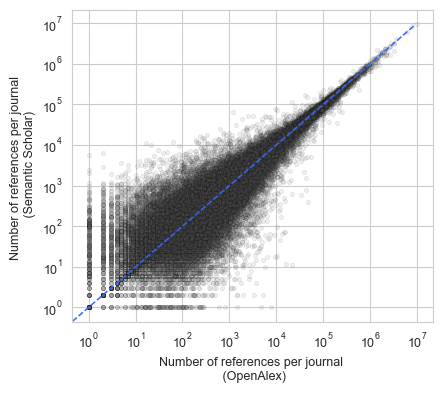

In [61]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.grid(True)

x = [x for x in range(1**1-1, 10**7, 1000000)]
y = x

sns.scatterplot(data=oal_s2_ref_sum_per_journal, 
                x='oal_ref_sum', 
                y='s2_ref_sum',
                marker='.',
                alpha=.1,
                edgecolor='#000000',
                color='#666666')

sns.lineplot(x=x, 
             y=y, 
             color='#3366FF', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set(xlabel='Number of references per journal \n (OpenAlex)', ylabel='Number of references per journal \n (Semantic Scholar)')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()
fig.savefig('media/oal_s2_ref_sum_per_journal.png', format='png', bbox_inches='tight', dpi=500)

In [111]:
oal_s2_ref_sum_per_publisher = client.query(f"""
                                           SELECT 
                                               SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                               SUM(s2.referencecount) AS s2_ref_sum,
                                               oal.primary_location.source.host_organization AS publisher_id,
                                               oal.primary_location.source.host_organization_name AS publisher_name
                                           FROM {openalex_snapshot} AS oal
                                           JOIN {s2ag_papers} AS s2
                                               ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                           WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                               AND oal.primary_location.source.type = 'journal'
                                               AND oal.type IN ('article', 'review') 
                                               AND is_paratext=False 
                                               AND is_retracted=False
                                           GROUP BY publisher_id, publisher_name
                                           """).to_dataframe()

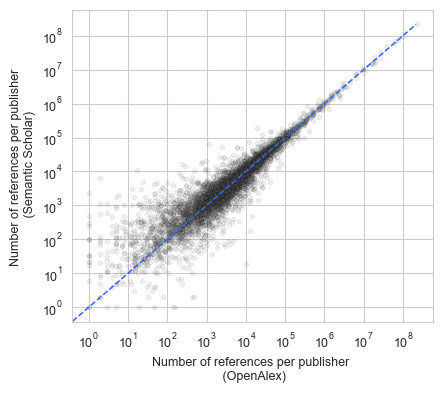

In [112]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.grid(True)

x = [x for x in range(1**1-1, 11**8, 1000000)]
y = x

sns.scatterplot(data=oal_s2_ref_sum_per_publisher, 
                x='oal_ref_sum', 
                y='s2_ref_sum',
                marker='.',
                alpha=.1,
                edgecolor='#000000',
                color='#666666')

sns.lineplot(x=x, 
             y=y, 
             color='#3366FF', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set(xlabel='Number of references per publisher \n (OpenAlex)', ylabel='Number of references per publisher \n (Semantic Scholar)')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()
fig.savefig('media/oal_s2_ref_sum_per_publisher.png', format='png', bbox_inches='tight', dpi=500)

In [113]:
oal_s2_ref_sum_per_publisher[oal_s2_ref_sum_per_publisher.s2_ref_sum > oal_s2_ref_sum_per_publisher.oal_ref_sum] \
    .sort_values(by=['s2_ref_sum'], ascending=False) \
    .head(20)

,oal_ref_sum,s2_ref_sum,publisher_id,publisher_name
4653,63591747,68261150,https://openalex.org/P4310310987,Multidisciplinary Digital Publishing Institute
3862,58524445,62064300,None,None
3058,38428778,46110203,https://openalex.org/P4310320547,Taylor & Francis
1208,27245366,29840647,https://openalex.org/P4310320527,Frontiers Media
2033,19780360,23713074,https://openalex.org/P4310320017,SAGE Publishing
3698,9832846,10560188,https://openalex.org/P4310315671,Lippincott Williams & Wilkins
1943,9512481,10207939,https://openalex.org/P4310315706,Public Library of Science
3381,6808835,7921991,https://openalex.org/P4310311721,Cambridge University Press
1178,6447765,7395107,https://openalex.org/P4310319869,Hindawi Publishing Corporation
822,6050726,7117591,https://openalex.org/P4310319811,Emerald Publishing Limited


In [114]:
oal_s2_ref_sum_per_publisher['diff'] = oal_s2_ref_sum_per_publisher['oal_ref_sum'] - oal_s2_ref_sum_per_publisher['s2_ref_sum']

In [115]:
oal_s2_ref_sum_per_publisher \
    .sort_values(by=['diff'], ascending=False) \
    .head(20)

,oal_ref_sum,s2_ref_sum,publisher_id,publisher_name,diff
2035,221098550,217185902,https://openalex.org/P4310320990,Elsevier BV,3912648
2518,25816934,22115193,https://openalex.org/P4310320006,American Chemical Society,3701741
4070,18203600,14648828,https://openalex.org/P4310320556,Royal Society of Chemistry,3554772
3409,19562074,16887840,https://openalex.org/P4310311648,Oxford University Press,2674234
5696,75121716,72754359,https://openalex.org/P4310320595,Wiley,2367357
4267,9996522,7674923,https://openalex.org/P4310320261,American Physical Society,2321599
538,91912174,90553478,https://openalex.org/P4310319900,Springer Science+Business Media,1358696
3955,2515341,1469092,https://openalex.org/P4310320079,Bentham Science Publishers,1046249
2955,17313110,16510014,https://openalex.org/P4310320256,BioMed Central,803096
2933,15143213,14424743,https://openalex.org/P4310319965,Springer Nature,718470


In [116]:
oal_s2_ref_sum_per_publisher \
    .sort_values(by=['diff'], ascending=True) \
    .head(20)

,oal_ref_sum,s2_ref_sum,publisher_id,publisher_name,diff
3058,38428778,46110203,https://openalex.org/P4310320547,Taylor & Francis,-7681425
4653,63591747,68261150,https://openalex.org/P4310310987,Multidisciplinary Digital Publishing Institute,-4669403
2033,19780360,23713074,https://openalex.org/P4310320017,SAGE Publishing,-3932714
3862,58524445,62064300,None,None,-3539855
1208,27245366,29840647,https://openalex.org/P4310320527,Frontiers Media,-2595281
3717,2764702,3898740,https://openalex.org/P4310319847,Routledge,-1134038
3381,6808835,7921991,https://openalex.org/P4310311721,Cambridge University Press,-1113156
822,6050726,7117591,https://openalex.org/P4310319811,Emerald Publishing Limited,-1066865
1178,6447765,7395107,https://openalex.org/P4310319869,Hindawi Publishing Corporation,-947342
3698,9832846,10560188,https://openalex.org/P4310315671,Lippincott Williams & Wilkins,-727342


#### SAGE Publications
https://www.crossref.org/members/prep/179
#### Frontiers Media SA
https://www.crossref.org/members/prep/1965

In [55]:
oal_s2_ref_sum_avg_per_topic = client.query(f"""
                                             SELECT 
                                                 SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                                 AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                                 SUM(s2.referencecount) AS s2_ref_sum,
                                                 AVG(s2.referencecount) AS s2_ref_avg,
                                                 oal.primary_topic.domain.display_name AS primary_topic
                                             FROM {openalex_snapshot} AS oal
                                             JOIN {s2ag_papers} AS s2
                                                 ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                             WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                                 AND oal.primary_location.source.type = 'journal'
                                                 AND oal.type IN ('article', 'review') 
                                                 AND is_paratext=False 
                                                 AND is_retracted=False
                                             GROUP BY primary_topic
                                             """).to_dataframe()

In [59]:
oal_s2_ref_sum_avg_per_topic

,oal_ref_sum,oal_ref_avg,s2_ref_sum,s2_ref_avg,primary_topic
0,191680092,36.625827,190953855,36.487059,Life Sciences
1,235953838,23.902660,237839461,24.093678,Health Sciences
2,407198668,31.643654,400246309,31.103382,Physical Sciences
3,145744398,16.035306,163572762,17.996845,Social Sciences
4,2008830,1.398958,1650860,1.149666,None


In [63]:
oal_s2_ref_sum_avg_per_journal_topic = client.query(f"""
                                                     SELECT 
                                                         SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                                         AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                                         SUM(s2.referencecount) AS s2_ref_sum,
                                                         AVG(s2.referencecount) AS s2_ref_avg,
                                                         oal.primary_topic.domain.display_name AS primary_topic,
                                                         oal.primary_location.source.id AS journal_title
                                                     FROM {openalex_snapshot} AS oal
                                                     JOIN {s2ag_papers} AS s2
                                                         ON LOWER(oal.doi) = LOWER(s2.externalids.DOI)
                                                     WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                                         AND oal.primary_location.source.type = 'journal'
                                                         AND oal.type IN ('article', 'review') 
                                                         AND is_paratext=False 
                                                         AND is_retracted=False
                                                     GROUP BY primary_topic, journal_title
                                                     """).to_dataframe()

In [70]:
oal_s2_ref_sum_avg_per_journal_topic_plot = oal_s2_ref_sum_avg_per_journal_topic.copy()
oal_s2_ref_sum_avg_per_journal_topic_plot_temp = oal_s2_ref_sum_avg_per_journal_topic.copy()
oal_s2_ref_sum_avg_per_journal_topic_plot['src'] = 'OpenAlex'
oal_s2_ref_sum_avg_per_journal_topic_plot['ref_sum'] = oal_s2_ref_sum_avg_per_journal_topic_plot['oal_ref_sum']
oal_s2_ref_sum_avg_per_journal_topic_plot['ref_avg'] = oal_s2_ref_sum_avg_per_journal_topic_plot['oal_ref_avg']
oal_s2_ref_sum_avg_per_journal_topic_plot_temp['src'] = 'Semantic Scholar'
oal_s2_ref_sum_avg_per_journal_topic_plot_temp['ref_sum'] = oal_s2_ref_sum_avg_per_journal_topic_plot_temp['s2_ref_sum']
oal_s2_ref_sum_avg_per_journal_topic_plot_temp['ref_avg'] = oal_s2_ref_sum_avg_per_journal_topic_plot_temp['s2_ref_avg']

oal_s2_ref_sum_avg_per_journal_topic_plot = pd.concat([oal_s2_ref_sum_avg_per_journal_topic_plot, 
                                                      oal_s2_ref_sum_avg_per_journal_topic_plot_temp], 
                                                      ignore_index=True)

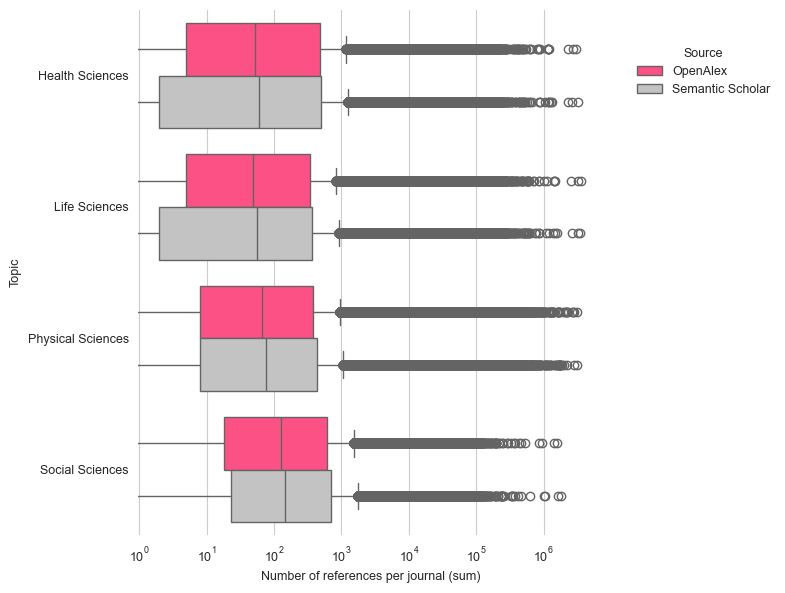

In [88]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.box(False)

palette = {'OpenAlex': '#fc5185',
           'Semantic Scholar': '#c3c3c3'}

sns.boxplot(x='ref_sum', 
            y='primary_topic', 
            hue='src', 
            data=oal_s2_ref_sum_avg_per_journal_topic_plot,
            palette=palette,
            #flierprops={'marker': '.', 'alpha': 0.1},
            saturation=1,
            ax=ax)

plt.xscale('log')

plt.xlabel('Number of references per journal (sum)')
plt.ylabel('Topic')

sns.despine(trim=True, left=True)

plt.legend(title='Source', frameon=False, bbox_to_anchor=(1.05, 0.95))

plt.tight_layout()
plt.show()
fig.savefig('media/s2_oal_sum_references_boxplot.png', format='png', bbox_inches='tight', dpi=500)

## Source references

In [33]:
oal_cr_s2_source_ref_y = client.query(f"""
                             SELECT 
                                 SUM(oal.referenced_works_count) AS oal_ref_sum, 
                                 AVG(oal.referenced_works_count) AS oal_ref_avg, 
                                 SUM(s2.source_ref_count) AS s2_ref_sum, 
                                 AVG(s2.source_ref_count) AS s2_ref_avg,
                                 SUM(cr.source_references_count) AS cr_ref_sum,
                                 AVG(cr.source_references_count) AS cr_ref_avg,
                                 oal.publication_year
                             FROM {openalex_snapshot} AS oal
                             JOIN (
                                 SELECT 
                                     s2.externalids.DOI AS doi, 
                                     CASE 
                                         WHEN source_ref_count IS NULL THEN 0
                                         ELSE source_ref_count
                                     END AS source_ref_count
                                 FROM {s2ag_papers} AS s2
                                 LEFT JOIN subugoe-collaborative.resources.s2_25022025_source_references AS s2_source_references
                                     ON s2.externalids.CorpusId = s2_source_references.corpus_id
                             ) AS s2
                                ON LOWER(oal.doi) = LOWER(s2.doi)
                             JOIN (
                                 SELECT doi, SUM(source_ref_count) AS source_references_count
                                 FROM (
                                     SELECT cr0.doi,
                                            CASE 
                                                WHEN ref.doi IS NOT NULL THEN 1 
                                                ELSE 0 
                                            END AS source_ref_count
                                     FROM {cr_snapshot} AS cr0, UNNEST(reference) AS ref
                                     WHERE issued >= '2015-01-01'AND issued < '2024-01-01' AND issued IS NOT NULL AND type = 'journal-article'
                                ) AS cr1
                                GROUP BY doi
                             ) AS cr
                                 ON LOWER(oal.doi) = LOWER(cr.doi)
                             WHERE oal.publication_year BETWEEN 2015 AND 2023 AND oal.primary_location.source.type = 'journal'
                                 AND oal.type IN ('article', 'review') AND is_paratext=False AND is_retracted=False
                             GROUP BY publication_year
                             """).to_dataframe()

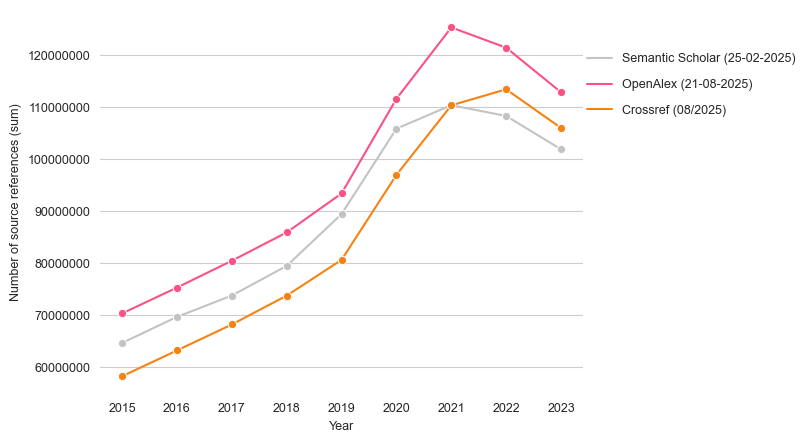

In [34]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_cr_s2_source_ref_y[['oal_ref_sum', 'publication_year']],
             x='publication_year',
             y='oal_ref_sum',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_source_ref_y[['s2_ref_sum', 'publication_year']],
             x='publication_year',
             y='s2_ref_sum',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_source_ref_y[['cr_ref_sum', 'publication_year']],
             x='publication_year',
             y='cr_ref_sum',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of source references (sum)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (21-08-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (08/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/oal_s2_cr_sum_source_ref.png', format='png', bbox_inches='tight', dpi=500)

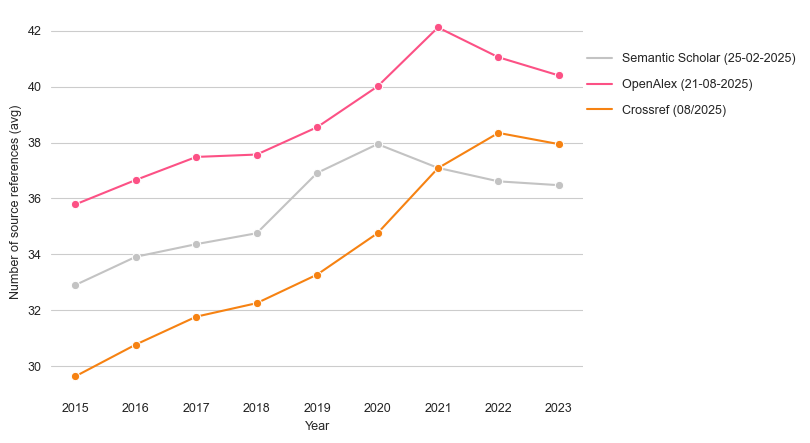

In [35]:
fig, ax = plt.subplots(figsize=(6,4.5))
plt.box(False)

sns.lineplot(data=oal_cr_s2_source_ref_y[['oal_ref_avg', 'publication_year']],
             x='publication_year',
             y='oal_ref_avg',
             color='#fc5185',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_source_ref_y[['s2_ref_avg', 'publication_year']],
             x='publication_year',
             y='s2_ref_avg',
             color='#c3c3c3',
             marker='o',
             ax=ax)

sns.lineplot(data=oal_cr_s2_source_ref_y[['cr_ref_avg', 'publication_year']],
             x='publication_year',
             y='cr_ref_avg',
             color='#f68212',
             marker='o',
             ax=ax)

ax.grid(False, which='both', axis='x')
ax.set(xlabel='Year', ylabel='Number of source references (avg)')
ax.ticklabel_format(useOffset=False, style='plain')

oal_patch = Line2D([0], [0], color='#fc5185', label='OpenAlex (21-08-2025)')
s2_patch = Line2D([0], [0], color='#c3c3c3', label='Semantic Scholar (25-02-2025)')
cr_patch = Line2D([0], [0], color='#f68212', label='Crossref (08/2025)')

lgd = fig.legend(handles=[s2_patch, oal_patch, cr_patch], frameon=False,
                 bbox_to_anchor=(1.35, 0.9), labelspacing=1.1)

plt.tight_layout()

plt.show()
fig.savefig(f'media/oal_s2_cr_avg_source_ref.png', format='png', bbox_inches='tight', dpi=500)

In [36]:
oal_cr_s2_source_ref_y.sort_values(by=['publication_year'])

,oal_ref_sum,oal_ref_avg,s2_ref_sum,s2_ref_avg,cr_ref_sum,cr_ref_avg,publication_year
5,70310721,35.786455,64644382,32.902425,58225479,29.635359,2015
8,75292872,36.661917,69646163,33.912398,63196921,30.772106,2016
2,80458771,37.484665,73759514,34.363570,68190066,31.768839,2017
4,85900452,37.569766,79463579,34.754509,73742324,32.252238,2018
0,93408914,38.548866,89442810,36.912097,80627358,33.274054,2019
6,111623501,40.007333,105866370,37.943902,96971409,34.755831,2020
1,125345047,42.118037,110388968,37.092544,110361427,37.083289,2021
3,121451832,41.051841,108312597,36.610659,113441551,38.344292,2022
7,112860440,40.399454,101893582,36.473764,105997136,37.942670,2023


In [37]:
oal_cr_s2_ref_y.oal_ref_sum.sum()

981092687

In [38]:
oal_cr_s2_ref_y.cr_ref_sum.sum()

980098734

In [39]:
oal_cr_s2_ref_y.s2_ref_sum.sum()

989707957

In [40]:
oal_s2_source_ref_sum_per_journal = client.query(f"""
                                   SELECT 
                                       SUM(oal.referenced_works_count) AS oal_source_ref_sum, 
                                       SUM(s2.source_ref_count) AS s2_source_ref_sum,
                                       oal.primary_location.source.id AS journal_title
                                   FROM {openalex_snapshot} AS oal
                                   JOIN (
                                     SELECT 
                                         s2.externalids.DOI AS doi, 
                                         CASE 
                                             WHEN source_ref_count IS NULL THEN 0
                                             ELSE source_ref_count
                                         END AS source_ref_count
                                     FROM {s2ag_papers} AS s2
                                     LEFT JOIN subugoe-collaborative.resources.s2_25022025_source_references AS s2_source_references
                                         ON s2.externalids.CorpusId = s2_source_references.corpus_id
                                   ) AS s2
                                       ON LOWER(oal.doi) = LOWER(s2.doi)
                                   WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                       AND oal.primary_location.source.type = 'journal'
                                       AND oal.type IN ('article', 'review') 
                                       AND is_paratext=False 
                                       AND is_retracted=False
                                   GROUP BY journal_title
                                   """).to_dataframe()

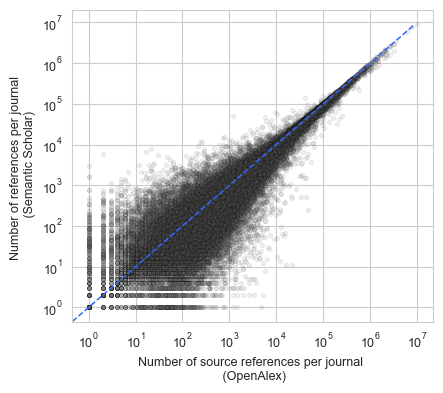

In [41]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.grid(True)

x = [x for x in range(1**1-1, 10**7, 1000000)]
y = x

sns.scatterplot(data=oal_s2_source_ref_sum_per_journal, 
                x='oal_source_ref_sum', 
                y='s2_source_ref_sum',
                marker='.',
                alpha=.1,
                edgecolor='#000000',
                color='#666666')

sns.lineplot(x=x, 
             y=y, 
             color='#3366FF', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set(xlabel='Number of source references per journal \n (OpenAlex)', ylabel='Number of references per journal \n (Semantic Scholar)')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()
fig.savefig('media/oal_s2_source_ref_sum_per_journal.png', format='png', bbox_inches='tight', dpi=500)

In [45]:
oal_s2_source_ref_sum_per_publisher = client.query(f"""
                                           SELECT 
                                               SUM(oal.referenced_works_count) AS oal_source_ref_sum, 
                                               SUM(s2.source_ref_count) AS s2_source_ref_sum,
                                               oal.primary_location.source.host_organization AS publisher_id,
                                               oal.primary_location.source.host_organization_name AS publisher_name
                                           FROM {openalex_snapshot} AS oal
                                           JOIN (
                                                 SELECT 
                                                     s2.externalids.DOI AS doi, 
                                                     CASE 
                                                         WHEN source_ref_count IS NULL THEN 0
                                                         ELSE source_ref_count
                                                     END AS source_ref_count
                                                 FROM {s2ag_papers} AS s2
                                                 LEFT JOIN subugoe-collaborative.resources.s2_25022025_source_references AS s2_source_references
                                                     ON s2.externalids.CorpusId = s2_source_references.corpus_id
                                             ) AS s2
                                                ON LOWER(oal.doi) = LOWER(s2.doi)
                                           WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                               AND oal.primary_location.source.type = 'journal'
                                               AND oal.type IN ('article', 'review') 
                                               AND is_paratext=False 
                                               AND is_retracted=False
                                           GROUP BY publisher_id, publisher_name
                                           """).to_dataframe()

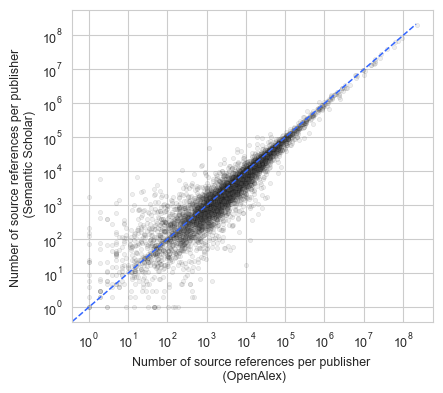

In [46]:
fig, ax = plt.subplots(figsize=(4.5, 4))

plt.grid(True)

x = [x for x in range(1**1-1, 11**8, 1000000)]
y = x

sns.scatterplot(data=oal_s2_source_ref_sum_per_publisher, 
                x='oal_source_ref_sum', 
                y='s2_source_ref_sum',
                marker='.',
                alpha=.1,
                edgecolor='#000000',
                color='#666666')

sns.lineplot(x=x, 
             y=y, 
             color='#3366FF', 
             linestyle='dashed', 
             linewidth=1.1,
             alpha=1)

ax.set(xlabel='Number of source references per publisher \n (OpenAlex)', 
       ylabel='Number of source references per publisher \n (Semantic Scholar)')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()
plt.show()
fig.savefig('media/oal_s2_source_ref_sum_per_publisher.png', format='png', bbox_inches='tight', dpi=500)

In [47]:
oal_s2_source_ref_sum_per_publisher['diff'] = oal_s2_source_ref_sum_per_publisher['oal_source_ref_sum'] - oal_s2_source_ref_sum_per_publisher['s2_source_ref_sum']

In [48]:
oal_s2_source_ref_sum_per_publisher \
    .sort_values(by=['diff'], ascending=False) \
    .head(20)

,oal_source_ref_sum,s2_source_ref_sum,publisher_id,publisher_name,diff
4212,221098550,208460916,https://openalex.org/P4310320990,Elsevier BV,12637634
1083,58524445,46853039,None,None,11671406
2103,91912174,82755155,https://openalex.org/P4310319900,Springer Science+Business Media,9157019
3450,75121716,67664721,https://openalex.org/P4310320595,Wiley,7456995
489,25816934,21628791,https://openalex.org/P4310320006,American Chemical Society,4188143
2983,18203600,14255451,https://openalex.org/P4310320556,Royal Society of Chemistry,3948149
4058,19562074,15847098,https://openalex.org/P4310311648,Oxford University Press,3714976
1375,9996522,6651643,https://openalex.org/P4310320261,American Physical Society,3344879
2731,17313110,15205127,https://openalex.org/P4310320256,BioMed Central,2107983
2401,15143213,13396255,https://openalex.org/P4310319965,Springer Nature,1746958


In [49]:
oal_s2_source_ref_sum_per_publisher \
    .sort_values(by=['diff'], ascending=True) \
    .head(20)

,oal_source_ref_sum,s2_source_ref_sum,publisher_id,publisher_name,diff
6231,27245366,28043664,https://openalex.org/P4310320527,Frontiers Media,-798298
262,6050726,6629422,https://openalex.org/P4310319811,Emerald Publishing Limited,-578696
1240,19780360,20292611,https://openalex.org/P4310320017,SAGE Publishing,-512251
3539,707064,1069281,https://openalex.org/P4310320466,OMICS Publishing Group,-362217
1197,38428778,38697631,https://openalex.org/P4310320547,Taylor & Francis,-268853
2335,349881,612388,https://openalex.org/P4310320855,Sciencedomain International,-262507
4416,6447765,6696983,https://openalex.org/P4310319869,Hindawi Publishing Corporation,-249218
247,1507041,1719281,https://openalex.org/P4310319798,Association for Computing Machinery,-212240
2259,1493723,1655240,https://openalex.org/P4310317820,Karger Publishers,-161517
2546,2069755,2221403,https://openalex.org/P4310320000,Thieme Medical Publishers (Germany),-151648


In [51]:
oal_s2_source_ref_sum_avg_per_topic = client.query(f"""
                                             SELECT 
                                                 SUM(oal.referenced_works_count) AS oal_source_ref_sum, 
                                                 AVG(oal.referenced_works_count) AS oal_source_ref_avg, 
                                                 SUM(s2.source_ref_count) AS s2_source_ref_sum,
                                                 AVG(s2.source_ref_count) AS s2_source_ref_avg,
                                                 oal.primary_topic.domain.display_name AS primary_topic
                                             FROM {openalex_snapshot} AS oal
                                             JOIN (
                                                 SELECT 
                                                     s2.externalids.DOI AS doi, 
                                                     CASE 
                                                         WHEN source_ref_count IS NULL THEN 0
                                                         ELSE source_ref_count
                                                     END AS source_ref_count
                                                 FROM {s2ag_papers} AS s2
                                                 LEFT JOIN subugoe-collaborative.resources.s2_25022025_source_references AS s2_source_references
                                                     ON s2.externalids.CorpusId = s2_source_references.corpus_id
                                             ) AS s2
                                                ON LOWER(oal.doi) = LOWER(s2.doi)
                                             WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                                 AND oal.primary_location.source.type = 'journal'
                                                 AND oal.type IN ('article', 'review') 
                                                 AND is_paratext=False 
                                                 AND is_retracted=False
                                             GROUP BY primary_topic
                                             """).to_dataframe()

In [52]:
oal_s2_source_ref_sum_avg_per_topic

,oal_source_ref_sum,oal_source_ref_avg,s2_source_ref_sum,s2_source_ref_avg,primary_topic
0,2008830,1.398958,1040406,0.724543,None
1,145744398,16.035306,132044159,14.527958,Social Sciences
2,407198668,31.643654,364822452,28.350572,Physical Sciences
3,235953838,23.902660,221164605,22.404477,Health Sciences
4,191680092,36.625827,177680421,33.950799,Life Sciences


In [42]:
oal_s2_source_ref_sum_avg_per_journal_topic = client.query(f"""
                             SELECT 
                                 SUM(oal.referenced_works_count) AS oal_source_ref_sum, 
                                 AVG(oal.referenced_works_count) AS oal_source_ref_avg, 
                                 SUM(s2.source_ref_count) AS s2_source_ref_sum, 
                                 AVG(s2.source_ref_count) AS s2_source_ref_avg,
                                 oal.primary_topic.domain.display_name AS primary_topic,
                                 oal.primary_location.source.id AS journal_title
                             FROM {openalex_snapshot} AS oal
                             JOIN (
                                 SELECT 
                                     s2.externalids.DOI AS doi, 
                                     CASE 
                                         WHEN source_ref_count IS NULL THEN 0
                                         ELSE source_ref_count
                                     END AS source_ref_count
                                 FROM {s2ag_papers} AS s2
                                 LEFT JOIN subugoe-collaborative.resources.s2_25022025_source_references AS s2_source_references
                                     ON s2.externalids.CorpusId = s2_source_references.corpus_id
                             ) AS s2
                                ON LOWER(oal.doi) = LOWER(s2.doi)
                             WHERE oal.publication_year BETWEEN 2015 AND 2023 
                                 AND oal.primary_location.source.type = 'journal'
                                 AND oal.type IN ('article', 'review') 
                                 AND is_paratext=False 
                                 AND is_retracted=False
                             GROUP BY primary_topic, journal_title
                             """).to_dataframe()

In [43]:
oal_s2_source_ref_sum_avg_per_journal_topic_plot = oal_s2_source_ref_sum_avg_per_journal_topic.copy()
oal_s2_source_ref_sum_avg_per_journal_topic_plot_temp = oal_s2_source_ref_sum_avg_per_journal_topic.copy()
oal_s2_source_ref_sum_avg_per_journal_topic_plot['src'] = 'OpenAlex'
oal_s2_source_ref_sum_avg_per_journal_topic_plot['source_ref_sum'] = oal_s2_source_ref_sum_avg_per_journal_topic_plot['oal_source_ref_sum']
oal_s2_source_ref_sum_avg_per_journal_topic_plot['source_ref_avg'] = oal_s2_source_ref_sum_avg_per_journal_topic_plot['oal_source_ref_avg']
oal_s2_source_ref_sum_avg_per_journal_topic_plot_temp['src'] = 'Semantic Scholar'
oal_s2_source_ref_sum_avg_per_journal_topic_plot_temp['source_ref_sum'] = oal_s2_source_ref_sum_avg_per_journal_topic_plot_temp['s2_source_ref_sum']
oal_s2_source_ref_sum_avg_per_journal_topic_plot_temp['source_ref_avg'] = oal_s2_source_ref_sum_avg_per_journal_topic_plot_temp['s2_source_ref_avg']

oal_s2_source_ref_sum_avg_per_journal_topic_plot = pd.concat([oal_s2_source_ref_sum_avg_per_journal_topic_plot, 
                                                              oal_s2_source_ref_sum_avg_per_journal_topic_plot_temp], 
                                                              ignore_index=True)

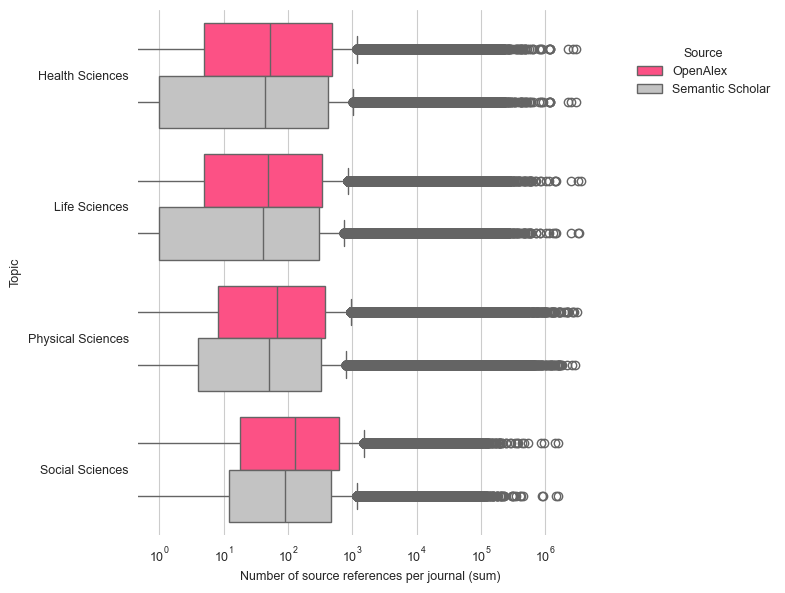

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.box(False)

palette = {'OpenAlex': '#fc5185',
           'Semantic Scholar': '#c3c3c3'}

sns.boxplot(x='source_ref_sum', 
            y='primary_topic', 
            hue='src', 
            data=oal_s2_source_ref_sum_avg_per_journal_topic_plot,
            palette=palette,
            #flierprops={'marker': '.', 'alpha': 0.1},
            saturation=1,
            ax=ax)

plt.xscale('log')

plt.xlabel('Number of source references per journal (sum)')
plt.ylabel('Topic')

sns.despine(trim=True, left=True)

plt.legend(title='Source', frameon=False, bbox_to_anchor=(1.05, 0.95))

plt.tight_layout()
plt.show()
fig.savefig('media/s2_oal_sum_source_references_boxplot.png', format='png', bbox_inches='tight', dpi=500)